In [11]:
import os.path as op 
import xarray as xr 
import numpy as np 
from run_projection_test import SUBIDS, loadnii, loadfunc, OUTROOT, EXPERIMENTS, SIGNALS
# from analysis_scripts import x_array
import itertools 
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from pdb import set_trace
import json
import sys 
from scipy import stats

plt.rcParams.update({'font.size': 12})
cmap = np.array(plt.get_cmap('tab20').colors)
METHODS = ['tob', 'wb', 'tob_sp', 'wb_sp']
METHOD_title = dict(zip(METHODS, ["Tob.", "RC", "Tob-lsQR", "RC-lsQR"]))
METRIC = ['rms', 'max', 'min']
MASKED_RMS = lambda a,b,mask: np.sqrt(((a[mask] - b[mask])**2).mean())
SIGNAL_title = dict(zip(SIGNALS, ['flat', 'sine', 'random']))
EXPERIMENT_title = dict(zip(EXPERIMENTS, ['surface', 'surface + edge', 'hybrid + edge']))
# %qtconsole

In [12]:
N_SUBS = 45
vsv = x_array(coords={'experiment': EXPERIMENTS, 'sub': range(N_SUBS),
                      'signal': SIGNALS, 'meth': METHODS, 'metric': METRIC})
svs = x_array(coords={'experiment': EXPERIMENTS, 'sub': range(N_SUBS), 
                      'signal': SIGNALS, 'meth': METHODS, 'metric': METRIC})

activations = x_array(coords={'sub': range(N_SUBS), 'meth': ['tob', 'wb'], 
                              'space': ['vol', 'surf'], 'metric': ['max', 'count']})

for exp in EXPERIMENTS:
    for idx,sub in enumerate(SUBIDS()[:N_SUBS]):

        sd = op.join(OUTROOT, 'naive', sub)
        struth = loadfunc(op.join(sd, 'activation.func.gii'))
        count = (struth > 0.1).sum()
        for meth in ['tob', 'wb']:
            vol = loadnii(op.join(sd, '%s_activation.nii.gz' % meth))
            surf = loadfunc(op.join(sd, '%s_activation.func.gii' % meth))
            activations.loc[idx,meth,'vol','max'] = vol.max()
            activations.loc[idx,meth,'surf','max'] = surf.max()
            activations.loc[idx,meth,'surf','count'] = (surf > 0.1).sum() / count        
        
        for signal in SIGNALS: 
            sd = op.join(OUTROOT, exp, sub)
            vtruth = loadnii(op.join(sd, '%s.nii.gz' % signal)) 
            if exp == 'wm_cbf':
                vtruth += loadnii(op.join(sd, 'wm_%s.nii.gz' % signal)) 
            mask = (vtruth > 0)
            struth = loadfunc(op.join(sd, '%s.func.gii' % signal))
            smask = loadfunc(op.join(sd, 'smask.func.gii')).astype(np.bool)
            
            for meth in METHODS: 
                try: 
                    path = op.join(sd, '%s_v2n2v_%s.nii.gz' % (signal,meth))
                    comp = loadnii(path)
                    maxidx = np.argmax(vtruth[mask])
                    vsv.loc[exp,idx,signal,meth,'rms'] = MASKED_RMS(vtruth, comp, mask) / vtruth[mask][maxidx]
                    vsv.loc[exp,idx,signal,meth,'max'] = 100 * (comp[mask][maxidx] / vtruth[mask][maxidx])
                    vsv.loc[exp,idx,signal,meth,'min'] = comp[mask].min()
                except Exception as e:
                    print(e)
 

                try: 
                    path = op.join(sd, '%s_n2v2n_%s.func.gii' % (signal,meth))
                    comp = loadfunc(path)
                    comp = comp[:struth.size]
                    maxidx = np.argmax(struth[smask])
                    svs.loc[exp,idx,signal,meth,'rms'] = MASKED_RMS(struth, comp, smask) / struth[smask][maxidx]
                    svs.loc[exp,idx,signal,meth,'max'] = 100 * (comp[smask][maxidx] / struth[smask][maxidx])
                    svs.loc[exp,idx,signal,meth,'min'] = comp[smask].min()
                except Exception as e:
                    print(e)


NameError: name 'x_array' is not defined

In [13]:
if not sys.platform.startswith('darwin'):
    svs.to_netcdf('svs.nc')
    vsv.to_netcdf('vsv.nc')
    activations.to_netcdf('activations.nc')
    
vsv = xr.open_dataarray('vsv.nc')
svs = xr.open_dataarray('svs.nc')
activations = xr.open_dataarray('activations.nc')

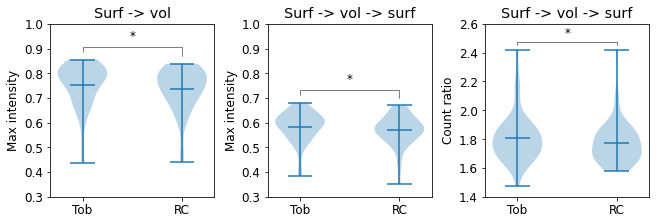

In [14]:
fig, axes = plt.subplots(1, 3, constrained_layout=True)
fig.set_size_inches(9,3)

for idx,(ax,title) in enumerate(zip(axes, ['Surf -> vol', 'Surf -> vol -> surf'])):

    data = activations[:,:,idx,0].T
    ax.violinplot(data.T, showmeans=True)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['Tob', 'RC'])
    ax.set_title(title)
    ax.set_ylim(0.3,1.0)
    ax.set_ylabel("Max intensity")
    
    y1 = data[0,:].max() + 0.03
    y2 = data[1,:].max() + 0.03
    ymax = max([y1,y2])
    h = 0.02
    ax.plot([1,1,2,2], [y1,ymax+h,ymax+h,y2], c='k', lw=0.5)
    p = stats.ttest_rel(*data).pvalue
    ceil_power = np.ceil(np.log10(p))
    if ceil_power <= -3: 
        ax.text(1.5, ymax+0.02+h, "*" % ceil_power % p, ha='center', va='bottom')

ax = axes[2]
data = activations[:,:,1,1].T
ax.violinplot(data.T, showmeans=True)
ax.set_xticks([1,2])
ax.set_xticklabels(['Tob', 'RC'])
ax.set_title("Surf -> vol -> surf")
ax.set_ylabel("Count ratio")
ax.set_ylim(1.4, 2.6)

y1 = data[0,:].max() + 0.03
y2 = data[1,:].max() + 0.03
ymax = max([y1,y2])
h = 0.02
ax.plot([1,1,2,2], [y1,ymax+h,ymax+h,y2], c='k', lw=0.5)
p = stats.ttest_rel(*data).pvalue
ceil_power = np.ceil(np.log10(p))
if ceil_power <= -3: 
    ax.text(1.5, ymax+0.02+h, "*" % ceil_power % p, ha='center', va='bottom')


plt.savefig('figures/activation_results.png', dpi=250)
plt.show()

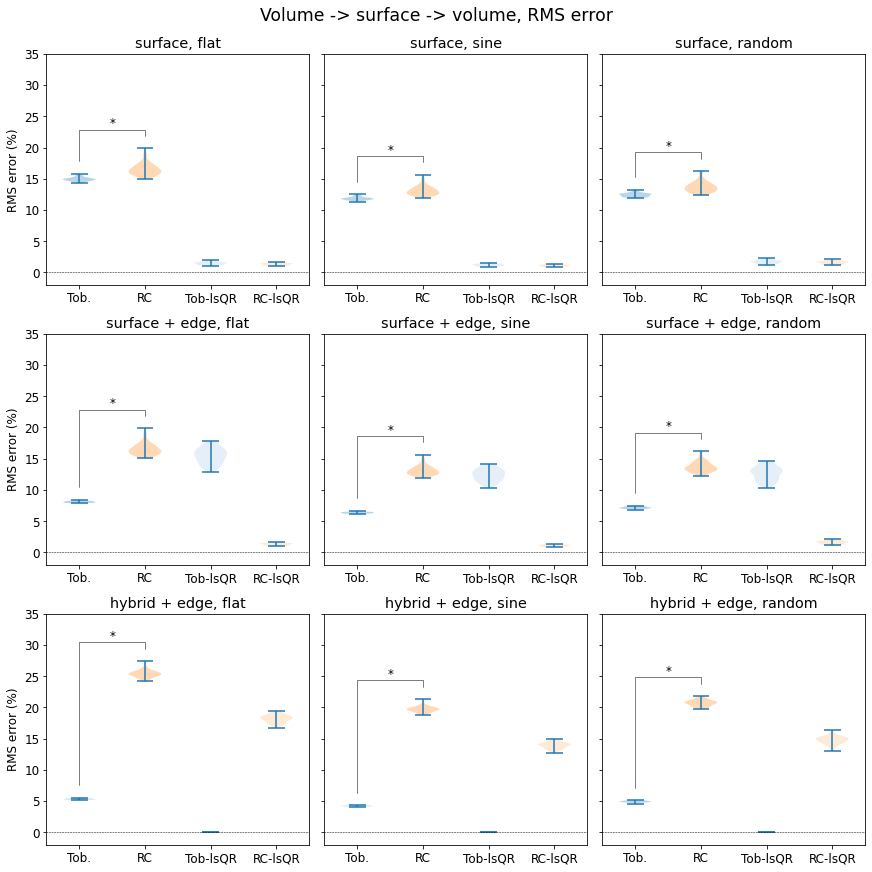

In [15]:
fig, axes = plt.subplots(3,3, constrained_layout=True, sharey=True, figsize=(12,12))
for expidx,exp in enumerate(EXPERIMENTS):
    for idx,ax in enumerate(axes[expidx,:]):
        
        data = 100 * vsv[expidx,:,idx,:,0].T
        ax.set_title('%s, %s' % (EXPERIMENT_title[exp], SIGNAL_title[SIGNALS[idx]]))    
        violins = ax.violinplot(data.T)
        [v.set_facecolor(cmap[c,:]) for c,v in zip([0,2,1,3], violins['bodies'])]
        ax.set_xticks(range(1,5))
        ax.set_xticklabels(METHOD_title.values())
        ax.set_ylim(-2, 35)
        if idx == 0: ax.set_ylabel("RMS error (%)")
        ax.plot([0,5], [0,0], 'k--', linewidth=0.5)
        ax.set_xlim(0.5, 4.5)
        
        data = data[:2,...]
        y1 = data[0,...].max() + 2
        y2 = data[1,...].max() + 2
        ymax = max([y1,y2])
        h = 1
        ax.plot([1,1,2,2], [y1,ymax+h,ymax+h,y2], c='k', lw=0.5)
        p = stats.ttest_rel(*data[:2,...]).pvalue
        ceil_power = np.ceil(np.log10(p))
        if ceil_power <= -3: 
            ax.text(1.5, ymax+h, "*" % ceil_power % p, ha='center', va='bottom')  

fig.suptitle('Volume -> surface -> volume, RMS error', fontsize='x-large')
plt.savefig('figures/VSV_violins.png', dpi=250)
plt.show()

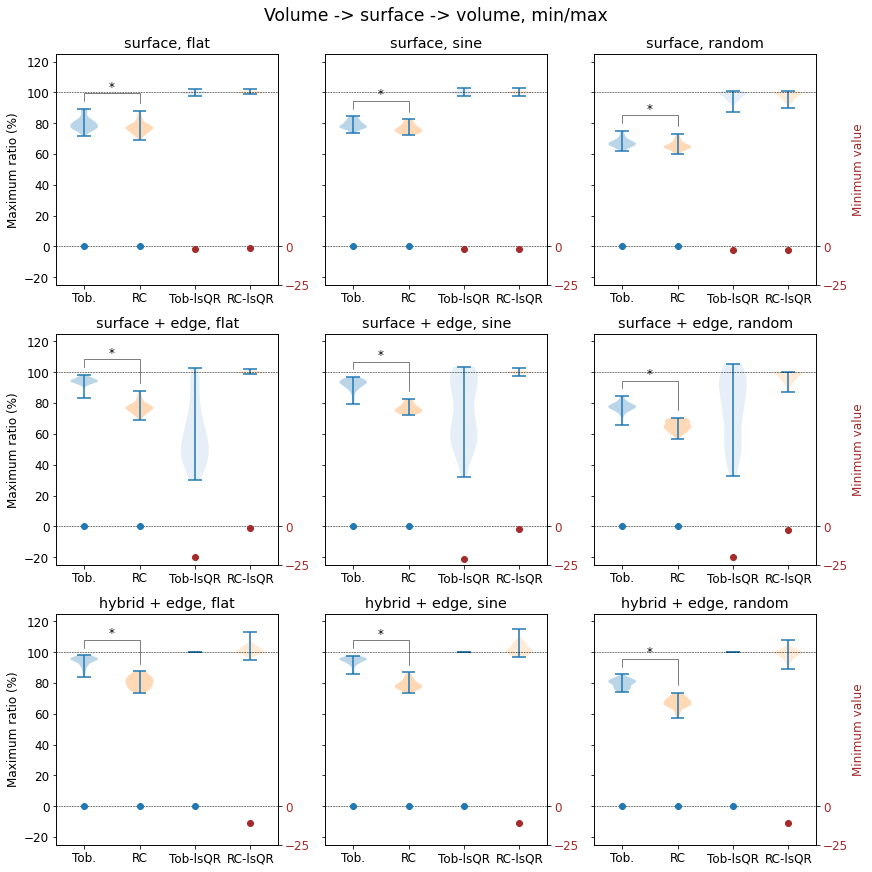

In [16]:
fig, axes = plt.subplots(3,3, constrained_layout=True, sharey=True, figsize=(12,12))
for expidx,exp in enumerate(EXPERIMENTS):
    for idx,ax in enumerate(axes[expidx,:]):
        ax.set_title('%s, %s' % (EXPERIMENT_title[exp], SIGNAL_title[SIGNALS[idx]]))    
        ax.set_xticks(range(1,5))
        ax.set_xlim(0.5,4.5)
        ax.set_xticklabels(METHOD_title.values())
        if idx == 0: ax.set_ylabel("Maximum ratio (%)")
        ax.set_ylim(-25,125)
        ax.plot([0,5], [100,100], 'k--', linewidth=0.5)
        ax.plot([0,5], [0,0], 'k--', linewidth=0.5)
        
        data = vsv[expidx,:,idx,:,1].T
        violins = ax.violinplot(data.T)
        [v.set_facecolor(cmap[c,:]) for c,v in zip([0,2,1,3], violins['bodies'])]
            
        data = data[:2,...]
        y1 = data[0,...].max() + 5
        y2 = data[1,...].max() + 5
        ymax = max([y1,y2])
        h = 5
        ax.plot([1,1,2,2], [y1,ymax+h,ymax+h,y2], c='k', lw=0.5)
        p = stats.ttest_rel(*data[:2,...]).pvalue
        ceil_power = np.ceil(np.log10(p))
        if ceil_power <= -3: 
            ax.text(1.5, ymax+h, "*" % ceil_power % p, ha='center', va='bottom') 

        ax2 = ax.twinx()
        data = vsv[expidx,:,idx,:,2].mean('sub').T
        low = (data < -1e-2)
        ax2.scatter(np.flatnonzero(low)+1, data[low], c='brown')
        ax2.scatter(np.flatnonzero(~low)+1, data[~low])
        ax2.set_ylim(-25,125)
        if idx == 2: ax2.set_ylabel("Minimum value", color='brown')
        ax2.set_yticks([-25,0])
        ax2.tick_params(axis='y', labelcolor='brown')
        
fig.suptitle('Volume -> surface -> volume, min/max', fontsize='x-large')
plt.savefig('figures/VSV_minmax.png', dpi=250)
plt.show()

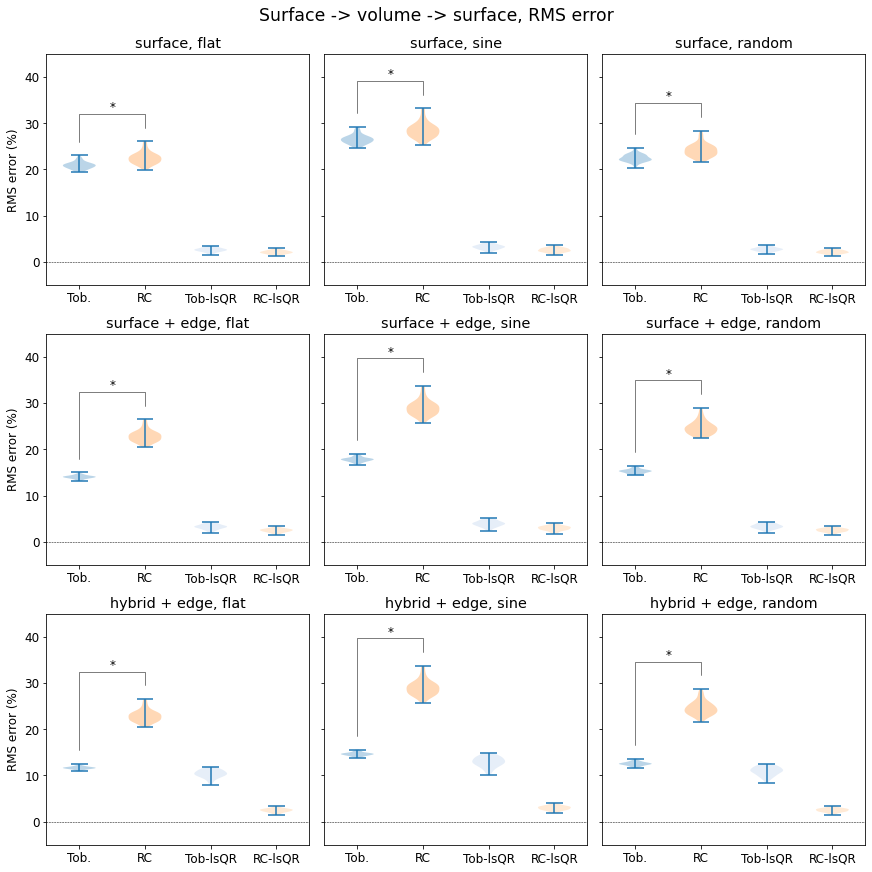

In [17]:
fig, axes = plt.subplots(3,3, constrained_layout=True, sharey=True, figsize=(12,12))
for expidx,exp in enumerate(EXPERIMENTS):
    for idx,ax in enumerate(axes[expidx,:]):
        data = 100 * svs[expidx,:,idx,:,0].T
        ax.set_title('%s, %s' % (EXPERIMENT_title[exp], SIGNAL_title[SIGNALS[idx]]))      
        ax.set_xticks(range(1,5))
        ax.set_xticklabels(METHOD_title.values())
        ax.set_ylim(-5, 45)
        if idx == 0: ax.set_ylabel("RMS error (%)")
        violins = ax.violinplot(data.T)
        [v.set_facecolor(cmap[c,:]) for c,v in zip([0,2,1,3], violins['bodies'])]
        ax.plot([0,5], [0,0], 'k--', linewidth=0.5)
        ax.set_xlim(0.5, 4.5)
        
        data = data[:2,...]
        y1 = data[0,...].max() + 3
        y2 = data[1,...].max() + 3
        ymax = max([y1,y2])
        h = 3
        ax.plot([1,1,2,2], [y1,ymax+h,ymax+h,y2], c='k', lw=0.5)
        p = stats.ttest_rel(*data[:2,...]).pvalue
        ceil_power = np.ceil(np.log10(p))
        if ceil_power <= -3: 
            ax.text(1.5, ymax+h, "*" % ceil_power % p, ha='center', va='bottom') 
            
fig.suptitle('Surface -> volume -> surface, RMS error', fontsize='x-large')
plt.savefig('figures/SVS_violins.png', dpi=250)
plt.show()

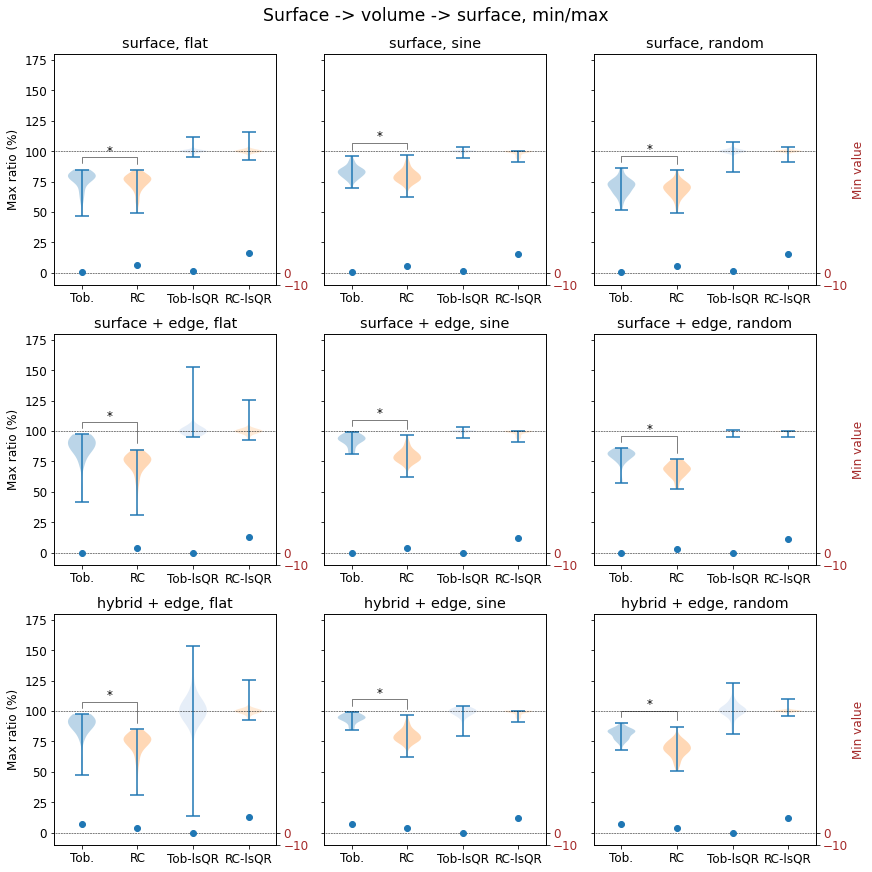

In [18]:
fig, axes = plt.subplots(3,3, constrained_layout=True, sharey=True, figsize=(12,12))
ylims = (-10, 180)
for expidx,exp in enumerate(EXPERIMENTS):
    for idx,ax in enumerate(axes[expidx,:]):
        ax.set_title('%s, %s' % (EXPERIMENT_title[exp], SIGNAL_title[SIGNALS[idx]]))    
        ax.set_xticks(range(1,5))
        ax.set_xlim(0.5,4.5)
        ax.set_xticklabels(METHOD_title.values())
        if idx == 0: ax.set_ylabel("Max ratio (%)")
        ax.set_ylim(ylims)
        ax.plot([0,5], [100,100], 'k--', linewidth=0.5)
        ax.plot([0,5], [0,0], 'k--', linewidth=0.5)
        
        data = svs[expidx,:,idx,:,1].T
        violins = ax.violinplot(data.T)
        [v.set_facecolor(cmap[c,:]) for c,v in zip([0,2,1,3], violins['bodies'])]
        
        data = data[:2,...]
        y1 = data[0,...].max() + 5
        y2 = data[1,...].max() + 5
        ymax = max([y1,y2])
        h = 5
        ax.plot([1,1,2,2], [y1,ymax+h,ymax+h,y2], c='k', lw=0.5)
        p = stats.ttest_rel(*data[:2,...]).pvalue
        ceil_power = np.ceil(np.log10(p))
        if ceil_power <= -3: 
            ax.text(1.5, ymax+h, "*" % ceil_power % p, ha='center', va='bottom')

        ax2 = ax.twinx()
        data = svs[expidx,:,idx,:,2].mean('sub').T
        low = (data < -1e-2)
        ax2.scatter(np.flatnonzero(low)+1, data[low], c='brown')
        ax2.scatter(np.flatnonzero(~low)+1, data[~low])
        ax2.set_ylim(ylims)
        if idx == 2: ax2.set_ylabel("Min value", color='brown')
        ax2.set_yticks([ylims[0],0])
        ax2.tick_params(axis='y', labelcolor='brown')
        
fig.suptitle('Surface -> volume -> surface, min/max', fontsize='x-large')
plt.savefig('figures/SVS_minmax.png', dpi=250)
plt.show()